# <u>Part 3:</u> Model training

<b><u>Authorss</u> :</b> Eytan Levy, Guillaume Surleau et Manitas Bahri  
<b><u>Date</u> :</b> March 2023

In [1]:
# Librairies import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

# Define the path to the parent directory
import sys
sys.path.append("../")

# Import the custom functions
from py_scripts.Model import Model


In [2]:
# Define objects
model = Model()


In [3]:
# Load the training, test and validation dataframes.
TRAIN, TEST, VALID = model.preproc.load_preproc_dataset()

# Split X and y from the dataframes.
(X_TRAIN, Y_TRAIN) = model.preproc.get_X_y(TRAIN)
(X_TEST, Y_TEST) = model.preproc.get_X_y(TEST)
(X_VALID, Y_VALID) = model.preproc.get_X_y(VALID)


## <u><b>I. Applying the synthetic undersampling strategy</b></u>

In [4]:
# Apply undersampling to data due to the imbalance of the data.
X_TRAIN, Y_TRAIN = model.preproc.undersampling(X_TRAIN, Y_TRAIN)
X_TEST, Y_TEST = model.preproc.undersampling(X_TEST, Y_TEST)
X_VALID, Y_VALID = model.preproc.undersampling(X_VALID, Y_VALID)

# Apply PCA to the data.
X_TRAIN = model.preproc.apply_pca(X_TRAIN, model.n_pca)
X_TEST = model.preproc.apply_pca(X_TEST, model.n_pca)
X_VALID = model.preproc.apply_pca(X_VALID, model.n_pca)


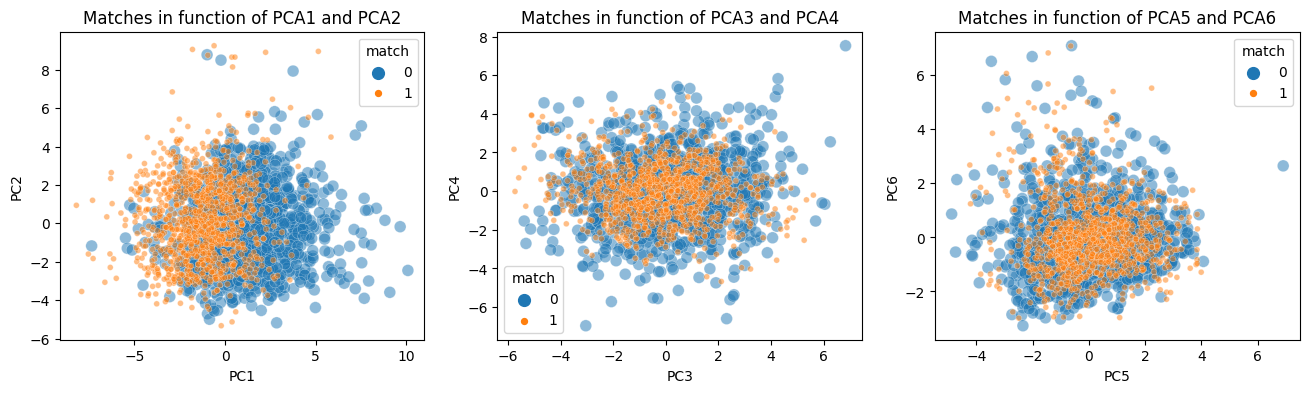

In [5]:
data = pd.concat([X_TRAIN, Y_TRAIN], axis=1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x="PC1", y="PC2", hue="match", data=data, size="match", alpha=.5)
plt.title("Matches in function of PCA1 and PCA2")

plt.subplot(1, 3, 2)
sns.scatterplot(x="PC3", y="PC4", hue="match", data=data, size="match", alpha=.5)
plt.title("Matches in function of PCA3 and PCA4")

plt.subplot(1, 3, 3)
sns.scatterplot(x="PC5", y="PC6", hue="match", data=data, size="match", alpha=.5)
plt.title("Matches in function of PCA5 and PCA6")

plt.show()

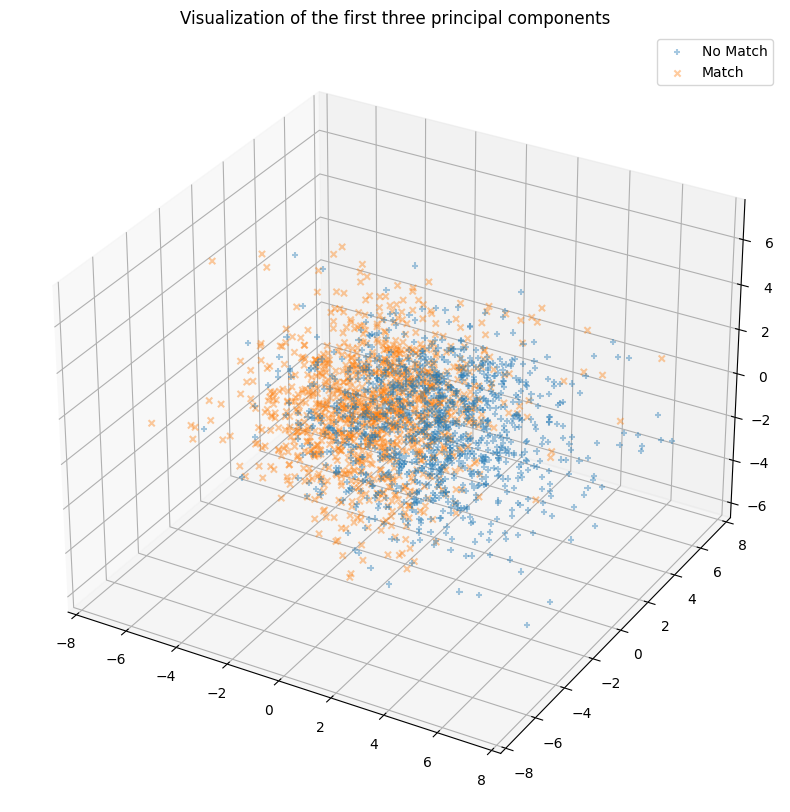

In [6]:
# Get the data of the match and no match
data_nomatch = data[data["match"] == 0]
data_match = data[data["match"] == 1]

# Plot the first three principal components in 3D
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

ax.scatter(data_nomatch["PC1"], data_nomatch["PC2"], data_nomatch["PC3"], alpha=0.4, marker="+", label="No Match")
ax.scatter(data_match["PC1"], data_match["PC2"], data_match["PC3"], alpha=0.4, marker="x", label="Match")
ax.set_title("Visualization of the first three principal components")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.legend()

plt.show()

## <b><u>II. Machine learning algorithm</b></u>

In [7]:
# Convert dataframes to numpy arrays
Y_TRAIN = Y_TRAIN.values.ravel()
Y_TEST = Y_TEST.values.ravel()
Y_VALID = Y_VALID.values.ravel()

# Define parameters for the validation curve
params_cv = {"X": X_TRAIN, "y": Y_TRAIN,
             "cv": 5, "scoring": "f1_macro", "n_jobs": -1}



### <u>A. Random Forest classifier</u>

In [8]:
# Fit the model
model_name = "Random Forest"

rfc = RandomForestClassifier()
rfc.fit(X_TRAIN, Y_TRAIN)
y_pred = rfc.predict(X_TEST)

# Print the classification report
print(classification_report(Y_TEST, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.63      0.65       124
           1       0.65      0.70      0.68       124

    accuracy                           0.67       248
   macro avg       0.67      0.67      0.66       248
weighted avg       0.67      0.67      0.66       248



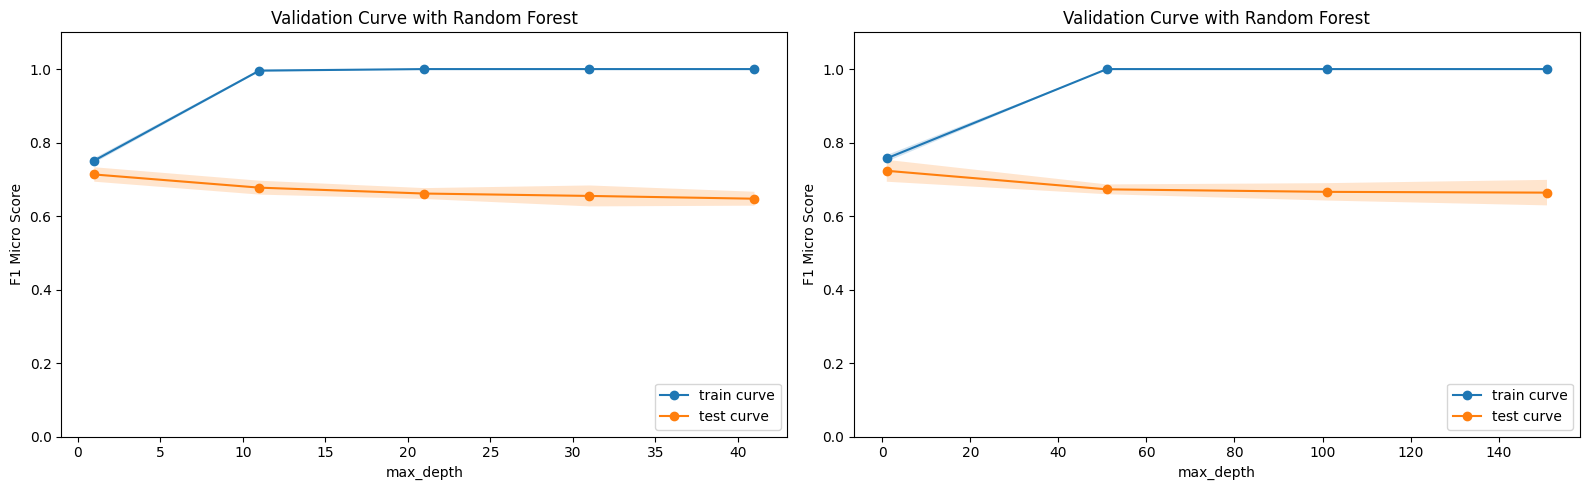

In [9]:
# Fit the model for max_depth
params_cv["param_name"] = "max_depth"
params_cv["param_range"] = np.arange(1, 50, 10)
params_cv["estimator"] = RandomForestClassifier(bootstrap=False)

sc_train, sc_test = validation_curve(**params_cv)

# Plot the validation curve
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
model.plot_validation_curve(sc_train, sc_test, model_name,
                            params_cv["param_name"], params_cv["param_range"])


# Fit the model for max_depth
params_cv["param_name"] = "max_depth"
params_cv["param_range"] = np.arange(1, 200, 50)
params_cv["estimator"] = RandomForestClassifier(bootstrap=True, oob_score=True, class_weight="balanced")

sc_train, sc_test = validation_curve(**params_cv)

# Plot the validation curve
plt.subplot(1, 2, 2)
model.plot_validation_curve(sc_train, sc_test, model_name,
                            params_cv["param_name"], params_cv["param_range"])


plt.tight_layout()
plt.show()


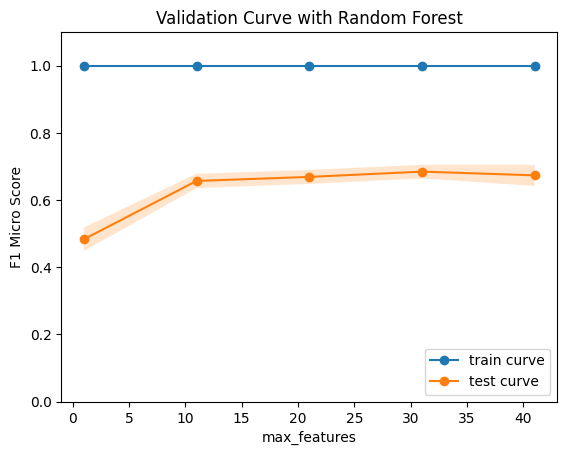

In [10]:
# Fit the model for max_depth
params_cv["param_name"] = "max_features"
params_cv["param_range"] = np.arange(1, 50, 10)
params_cv["estimator"] = RandomForestClassifier(bootstrap=False)

sc_train, sc_test = validation_curve(**params_cv)

# Plot the validation curve
model.plot_validation_curve(sc_train, sc_test, model_name,
                            params_cv["param_name"], params_cv["param_range"])


plt.show()


### <u>B. Support Vector Classification.</u>

In [11]:
# Fit the model
model_name = "SVC"

svc = SVC(random_state=0, kernel="poly")
svc.fit(X_TRAIN, Y_TRAIN)
y_pred = svc.predict(X_TEST)

# Print the classification report
print(classification_report(Y_TEST, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.56      0.60       124
           1       0.61      0.67      0.64       124

    accuracy                           0.62       248
   macro avg       0.62      0.62      0.62       248
weighted avg       0.62      0.62      0.62       248



/home/manitas/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/manitas/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/manitas/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=60).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/manitas/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/manitas/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver termin

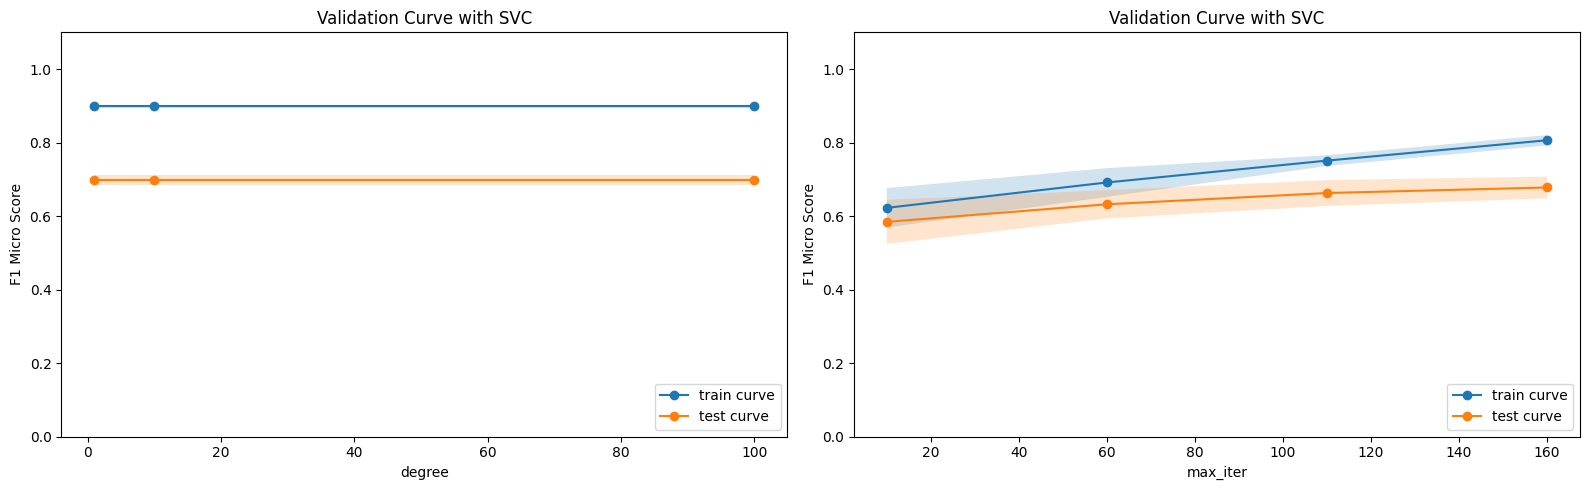

In [12]:
# Fit the model for max_depth
params_cv["param_name"] = "degree"
params_cv["param_range"] = [0.01, 0.1, 1, 10, 100]
params_cv["estimator"] = SVC()

sc_train, sc_test = validation_curve(**params_cv)

# Plot the validation curve
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
model.plot_validation_curve(sc_train, sc_test, model_name,
                            params_cv["param_name"], params_cv["param_range"])


# Fit the model for max_depth
params_cv["param_name"] = "max_iter"
params_cv["param_range"] = np.arange(10, 200, 50)
params_cv["estimator"] = SVC()

sc_train, sc_test = validation_curve(**params_cv)

# Plot the validation curve
plt.subplot(1, 2, 2)
model.plot_validation_curve(sc_train, sc_test, model_name,
                            params_cv["param_name"], params_cv["param_range"])


plt.tight_layout()
plt.show()


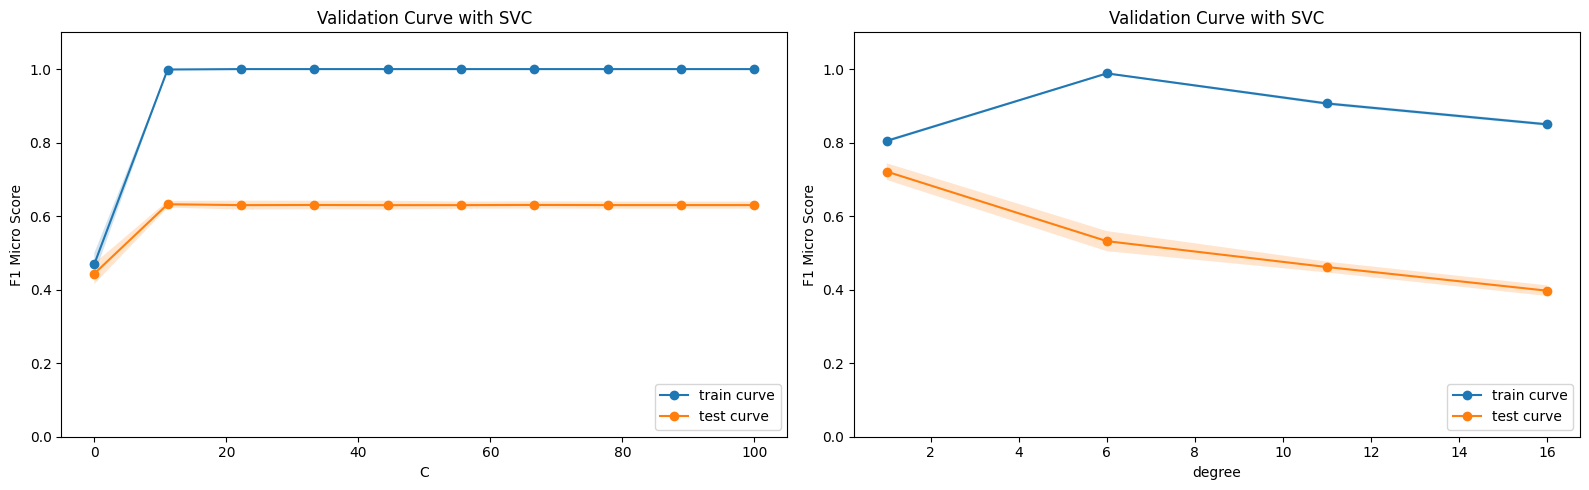

In [13]:
# Fit the model for max_depth
params_cv["param_name"] = "C"
params_cv["param_range"] = np.linspace(0.01, 100, 10)
params_cv["estimator"] = SVC(kernel="poly")

sc_train, sc_test = validation_curve(**params_cv)

# Plot the validation curve
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
model.plot_validation_curve(sc_train, sc_test, model_name,
                            params_cv["param_name"], params_cv["param_range"])


# Fit the model for max_depth
params_cv["param_name"] = "degree"
params_cv["param_range"] = np.arange(1, 20, 5)
params_cv["estimator"] = SVC(C=20, kernel="poly")

sc_train, sc_test = validation_curve(**params_cv)

# Plot the validation curve
plt.subplot(1, 2, 2)
model.plot_validation_curve(sc_train, sc_test, model_name,
                            params_cv["param_name"], params_cv["param_range"])


plt.tight_layout()
plt.show()


## III. Final model

In [14]:
# Fit the model
final_model = RandomForestClassifier(random_state=0, bootstrap=True,
                                     oob_score=True, class_weight="balanced", max_features=15)

final_model.fit(X_TRAIN, Y_TRAIN)
y_pred = final_model.predict(X_VALID)

print(classification_report(Y_VALID, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.71      0.74       143
           1       0.73      0.79      0.76       143

    accuracy                           0.75       286
   macro avg       0.75      0.75      0.75       286
weighted avg       0.75      0.75      0.75       286

